In [1]:
import numpy as np
from scipy.io import loadmat, savemat
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import pandas as pd
from tqdm import tqdm
import math

%matplotlib inline

In [52]:
def gen_images(locs, features, n_gridpoints, normalize=True,
               augment=False, pca=False, std_mult=0.1, n_components=2, edgeless=False):
    """
    Generates EEG images given electrode locations in 2D space and multiple feature values for each electrode

    :param locs: An array with shape [n_electrodes, 2] containing X, Y
                        coordinates for each electrode.
    :param features: Feature matrix as [n_samples, n_features]
                                Features are as columns.
                                Features corresponding to each frequency band are concatenated.
                                (alpha1, alpha2, ..., beta1, beta2,...)
    :param n_gridpoints: Number of pixels in the output images
    :param normalize:   Flag for whether to normalize each band over all samples
    :param augment:     Flag for generating augmented images
    :param pca:         Flag for PCA based data augmentation
    :param std_mult     Multiplier for std of added noise
    :param n_components: Number of components in PCA to retain for augmentation
    :param edgeless:    If True generates edgeless images by adding artificial channels
                        at four corners of the image with value = 0 (default=False).
    :return:            Tensor of size [samples, colors, W, H] containing generated
                        images.
    """
    locs = np.array(locs)
    features = features.reshape(np.shape(features)[0], np.shape(features)[1] * np.shape(features)[2])
    feat_array_temp = []
    nElectrodes = locs.shape[0]     # Number of electrodes
    # Test whether the feature vector length is divisible by number of electrodes
    assert features.shape[1] % nElectrodes == 0
    n_colors = int(features.shape[1] / nElectrodes)
    for c in range(n_colors):
        feat_array_temp.append(features[:, c * nElectrodes : nElectrodes * (c+1)])
    if augment:
        if pca:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=True, n_components=n_components)
        else:
            for c in range(n_colors):
                feat_array_temp[c] = augment_EEG(feat_array_temp[c], std_mult, pca=False, n_components=n_components)
    nSamples = features.shape[0]
    # Interpolate the values
    grid_x, grid_y = np.mgrid[
                     min(locs[:, 0]):max(locs[:, 0]):n_gridpoints*1j,
                     min(locs[:, 1]):max(locs[:, 1]):n_gridpoints*1j
                     ]
    temp_interp = []
    for c in range(n_colors):
        temp_interp.append(np.zeros([nSamples, n_gridpoints, n_gridpoints]))
    # Generate edgeless images
    if edgeless:
        min_x, min_y = np.min(locs, axis=0)
        max_x, max_y = np.max(locs, axis=0)
        locs = np.append(locs, np.array([[min_x, min_y], [min_x, max_y],[max_x, min_y],[max_x, max_y]]),axis=0)
        for c in range(n_colors):
            feat_array_temp[c] = np.append(feat_array_temp[c], np.zeros((nSamples, 4)), axis=1)
    # Interpolating
    for i in range(nSamples):
        for c in range(n_colors):
            temp_interp[c][i, :, :] = griddata(locs, feat_array_temp[c][i, :], (grid_x, grid_y),
                                    method='cubic', fill_value=np.nan)
#         print('Interpolating {0}/{1}\r'.format(i+1, nSamples), end='\r')
    
    # Normalizing
    for c in range(n_colors):
        if normalize:
            temp_interp[c][~np.isnan(temp_interp[c])] = \
                scale(temp_interp[c][~np.isnan(temp_interp[c])])
        temp_interp[c] = np.nan_to_num(temp_interp[c])    #Replace nan with zero and inf with large finite numbers.
    images = np.swapaxes(np.asarray(temp_interp), 0, 1)     # swap axes to have [samples, colors, W, H]
    
    images = np.transpose (images, (0, 3 ,2, 1))
    
    return images
    
def make_frames(df,frame_duration):
    '''
    in: dataframe or array with all channels, frame duration in seconds
    out: array of theta, alpha, beta averages for each probe for each time step
        shape: (n-frames,m-probes,k-brainwave bands)
    '''
    Fs = 256.0
    frame_length = Fs*frame_duration
    
    frames = []
    #print('df shape',np.shape(df))
    for i in range(0, np.shape(df)[0]):
        frame = []
        
        for channel in range(0, np.shape(df)[1]):
            snippet = df[i][channel]
            #print(i, channel)
            #f,Y =  get_fft(snippet)
            #print (len(snippet))
            theta, alpha, beta = theta_alpha_beta_averages(np.array(range(len(snippet))), snippet)
            #print (theta, alpha, beta)
            frame.append([theta, alpha, beta])
            
        frames.append(frame)
        if i == len(df)-1:
            print('===== %d end ====='%(i))
    frames = np.array(frames)
    return frames

def theta_alpha_beta_averages(f,Y):
    theta_range = (4,8)
    alpha_range = (8,13)
    beta_range = (13,30)
    theta = Y[(f>theta_range[0]) & (f<=theta_range[1])].mean()
    alpha = Y[(f>alpha_range[0]) & (f<=alpha_range[1])].mean()
    beta = Y[(f>beta_range[0]) & (f<=beta_range[1])].mean()
    return theta, alpha, beta


def convert_time_to_frequency(data_time):
    # convert from time to frequency domain
    data_time = np.transpose(data_time, (0, 2, 1))
    num_exp, num_ch, rate = data_time.shape
    
    data_freq = []
    # time-frequency convertion on all the EEG signals
    for i in range(num_exp):
        spectrum = []
        for ch in range(num_ch):
            time_domain = data_time[i][ch]
            f , magnitude = get_fft(time_domain)
            spectrum.append(magnitude)
        data_freq.append(spectrum)
    
    return np.array(data_freq)

def get_fft(snippet):
    Fs = 256.0;  # sampling rate
    y = snippet
    n = len(y) # length of the signal
    k = np.arange(n)
    T = n/Fs
    frq = k/T # two sides frequency range
    frq = frq[range(int(n/2))] # one side frequency range

    Y = np.fft.fft(y)/n # fft computing and normalization
    Y = Y[range(int(n/2))]
    return frq,abs(Y)

def get_2d_electrode_locations():
    # Load electrode locations
    locs = loadmat('Neuroscan_locs_orig.mat')
    locs_3d = locs['A']
    locs_2d = []
    # Convert to 2D
    for e in locs_3d:
        locs_2d.append(azim_proj(e))
    return np.array(locs_2d)

def azim_proj(pos):
    """
    Computes the Azimuthal Equidistant Projection of input point in 3D Cartesian Coordinates.
    Imagine a plane being placed against (tangent to) a globe. If
    a light source inside the globe projects the graticule onto
    the plane the result would be a planar, or azimuthal, map
    projection.

    :param pos: position in 3D Cartesian coordinates
    :return: projected coordinates using Azimuthal Equidistant Projection
    """
    [r, elev, az] = cart2sph(pos[0], pos[1], pos[2])
    return pol2cart(az, np.pi / 2 - elev)

def cart2sph(x, y, z):
    """
    Transform Cartesian coordinates to spherical
    :param x: X coordinate
    :param y: Y coordinate
    :param z: Z coordinate
    :return: radius, elevation, azimuth
    """
    x2_y2 = x**2 + y**2
    r = np.sqrt(x2_y2 + z**2)                    # r
    elev = np.arctan2(z, np.sqrt(x2_y2))            # Elevation
    az = np.arctan2(y, x)                          # Azimuth
    return r, elev, az

def pol2cart(theta, rho):
    """
    Transform polar coordinates to Cartesian
    :param theta: angle value
    :param rho: radius value
    :return: X, Y
    """
    return rho * np.cos(theta), rho * np.sin(theta)

In [35]:
# #########################################################
# def load_data(filename='ucieeg.mat'):
#     # load the .mat file
#     data_mat = loadmat(filename)
#     # create separate arrays for each feature/label
#     data_time = data_mat['X']
#     label_alcoholism = data_mat['y_alcoholic'].reshape(-1)
#     label_stimulus = data_mat['y_stimulus'].reshape(-1)
#     label_id = data_mat['subjectid'].reshape(-1)

#     # create dataframe of labels
#     labels = {
#         'alcoholism': label_alcoholism,
#         'stimulus': label_stimulus,
#         'id': label_id
#     }
#     df = pd.DataFrame(labels)

#     # remove all trials containing stimulus 3 and 4 (data) 
#     indices_stimulus_4 = df.loc[(df['stimulus'] == 4)].index
#     indices_stimulus_5 = df.loc[(df['stimulus'] == 5)].index
#     indices_stimulus_4_n_5 = np.array(indices_stimulus_4.append(indices_stimulus_5))
#     data_time = np.delete(data_time, indices_stimulus_4_n_5, 0)

#     # remove all trials containing stimulus 3 and 4 (labels)
#     num_samples = len(data_time)
#     indices_new = pd.Series(np.arange(0, num_samples))
#     df = df.drop(indices_stimulus_4_n_5, axis=0).set_index(indices_new)
#     return data_time, df

# # load the complete ucieeg dataset
# data_time, df = load_data('ucieeg.mat')
# # convert data from time to frequency domain
# data_freq = convert_time_to_frequency(data_time)

# savemat('ucieeg_freq.mat',  {'data_freq': data_freq, 'df': df})
# df.to_csv('df.csv', index=False)
# ####################################################

np.random.seed(0)
data_mat = loadmat('ucieeg_freq.mat')
data_freq = data_mat['data_freq']
df = pd.read_csv('df.csv')

# convert 3d locations of electrodes to 2d
locs_2d = get_2d_electrode_locations()



# create dummy signals (creates all 128 frequency channels)
# dummy = data_freq[:10] # TODO update this to actual class conditional dummy signals #

# create frames (extracts only the theta, aplha and beta channels (3))
# frames = make_frames(dummy, 1)

# convert signals to RGB images
# images = gen_images(locs_2d, frames, 32, normalize=False)

# extract unique labels
labels_unique_alcoholism = np.array(df['alcoholism'].value_counts().keys())
labels_unique_stimulus = np.array(df['stimulus'].value_counts().keys())
labels_unique_id = np.sort(np.array(df['id'].value_counts().keys()))

# for i in range(len(images)):
#     plt.figure()
#     plt.imshow(images[i])
#     plt.show()

===== 9 end =====
Interpolating 10/10

| | Alcoholism (0-1) | Stimulus (1-5) | Identity (1-122) |Comment|
| --- | --- | --- | --- | --- |
|1| T | T | T | Randomly select alcoholic individuals
|2| F | T | T | Randomly select NON-alcoholic individuals
|3| T | F | F | Take alcoholic individuals, select* random trials and avg
|4| F | F | F | Take NON-alcoholic individuals, select* random trials and avg
|5| T | F | T | From alcoholic individuals, fist randomly select a person, select* random trials containing that identity and avg
|6| F | F | T | From NON-alcoholic individuals, fist randomly select a person, select* random trials containing that identity and avg
|7| T | T | F | From alcoholic individuals, fist randomly select a stimulus, select* random trials containing that stimulus and avg
|8| F | T | F | From NON-alcoholic individuals, fist randomly select a stimulus, select* random trials containing that stimulus and avg

*select means randomly draw 3 or 5 trials and take the average

**averaged trials mean that they either contain or does not contain that feature, does not say anything a specific featuree (i.e. which stimulus/person)

1. How many trials to average over (to make sure it is a proper average/not from the same categories)?
2. How many samples to generate per condition?

In [29]:
def get_average_data(data_input, window_size):
    '''
        Returns the average of the data_input over the window_size
    '''
    data_avg_list = []
    for index in range(window_size//2, len(data_input)-window_size+(window_size//2)):
        start = index - window_size//2
        end = index +  window_size//2 + 1 

        indices = [index_a for index_a in range(start, end)]
        data_selected = data_freq[indices]
        data_avg = np.mean(data_selected, axis=0)
        data_avg_list.append(data_avg)
    data_avg_list = np.array(data_avg_list)
    return data_avg_list

def hide_identity_keep_stimulus(df, data_freq, alcoholism_condition, window_size=3, to_sample=2000, random_state=0):
    # V stands for variable alcoholism
    to_sample = to_sample // 3
    to_sample += window_size
    
    # extract the indices for the three different stimulus conditons with the specifiec alcoholism condition
    indices_V_1_T = df.query(f'alcoholism == {alcoholism_condition} and stimulus == 1').index
    indices_V_2_T = df.query(f'alcoholism == {alcoholism_condition} and stimulus == 2').index
    indices_V_3_T = df.query(f'alcoholism == {alcoholism_condition} and stimulus == 3').index
    
    # extract the corresponding entries in the dataframe 
    df_V_1_T = df.iloc[indices_V_1_T].sample(n=to_sample, replace=True, random_state=random_state)
    df_V_2_T = df.iloc[indices_V_2_T].sample(n=to_sample, replace=True, random_state=random_state)
    df_V_3_T = df.iloc[indices_V_3_T].sample(n=to_sample, replace=True, random_state=random_state)
    
    # TODO adapt a better sampling strategy to make sure that people with same identities 
    # do not end up in a given window size 
    
    # average over the identities, while keeping stimulus and alcoholism informaiton
    data_V_1_F = get_average_data(df_V_1_T, window_size)
    data_V_2_F = get_average_data(df_V_2_T, window_size)
    data_V_3_F = get_average_data(df_V_3_T, window_size)
    
    # stack the three different stimulius conditions into one
    data_V_T_F = np.vstack((data_V_1_F, data_V_2_F, data_V_3_F))
    
    return data_V_T_F

def hide_identity_hide_stimulus(df, data_freq, alcoholism_condition, window_size=3, to_sample=2000, random_state=0):
    # V stands for variable alcoholism
    to_sample += window_size
    
    # extract the indices corresponding to alcoholism
    indices_V_T_T = df.query(f'alcoholism == {alcoholism_condition}').index
    
    # extract the corresponding entries in the dataframe 
    df_V_T_T = df.iloc[indices_V_T_T].sample(n=to_sample, replace=True, random_state=random_state)
    
    # TODO adapt a better sampling strategy to make sure that people with same identities 
    # do not end up in a given window size 
    
    # average over the identities and stimulus while keeping alcoholism informaiton
    data_V_F_F = get_average_data(df_V_T_T, window_size)
    
    return data_V_F_F

def keep_identity_hide_stimulus(df, data_freq, alcoholism_condition, window_size=3, to_sample=2000, random_state=0):
    # V stands for variable alcoholism
    to_sample_in = to_sample
    if alcoholism_condition == 1:
        to_sample = to_sample // 77
    else:
        to_sample = to_sample // 20
    to_sample += window_size
    
    data_V_F_VI_array = []
    
    identity_range = np.arange(1, 123)
    for index_id in identity_range:
        # extract the indices corresponding to alcoholism
        indices_V_T_VI = df.query(f'alcoholism == {alcoholism_condition} and id == {index_id}').index
        if len(indices_V_T_VI) > 0:
            # extract the corresponding entries in the dataframe 
            df_V_T_VI = df.iloc[indices_V_T_VI].sample(n=to_sample, replace=True, random_state=random_state)
            
            # average over the stimulus, while keeping identity and alcoholism informaiton
            data_V_F_VI = get_average_data(indices_V_T_VI, window_size)
            if len(data_V_F_VI_array) == 0:
                data_V_F_VI_array = data_V_F_VI
            else:
                data_V_F_VI_array = np.vstack((data_V_F_VI_array, data_V_F_VI))
    if len(data_V_F_VI_array) > to_sample_in:
        data_V_F_VI_array = data_V_F_VI_array[np.random.choice(np.arange(to_sample_in), to_sample_in)]
    
    return data_V_F_VI_array

def keep_identity_keep_stimulus(df, data_freq, alcoholism_condition, window_size=3, to_sample=2000, random_state=0):
    # extract the indices corresponding to alcoholism
    indices_V_T_T = df.query(f'alcoholism == {alcoholism_condition}').index
    df_V_T_T = df.iloc[indices_V_T_T].sample(n=to_sample, replace=True, random_state=random_state)
    
    indices_V_T_T = df_V_T_T.index
    data_V_T_T = data_freq[indices_V_T_T]
    
    return data_V_T_T

In [5]:
# print(f'Alcoholism: {labels_unique_alcoholism}')
# print(f'Stimulus: {labels_unique_stimulus}')
# print(f'Identity: {labels_unique_id}')

window_size = 7
to_sample = 3000

Alcoholism: [1 0]
Stimulus: [1 3 2]
Identity: [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72
  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89  90
  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108
 109 110 111 112 113 114 115 116 117 118 119 120 121 122]


In [62]:
# 1. (T T T) Alcoholism + stimulus + identity
data_T_T_T = keep_identity_keep_stimulus(df, data_freq, alcoholism_condition=1, window_size=window_size, to_sample=to_sample)
print(f'T T T : {len(data_T_T_T)}')

# 2. (F T T) NO-Alcoholism + stimulus + identity
data_F_T_T = keep_identity_keep_stimulus(df, data_freq, alcoholism_condition=0, window_size=window_size, to_sample=to_sample)
print(f'F T T : {len(data_F_T_T)}')

# 3. (T F F) Alcoholism + NO-stimulus + NO-identity
data_T_F_F = hide_identity_hide_stimulus(df, data_freq, alcoholism_condition=1, window_size=window_size, to_sample=to_sample)
print(f'T F F : {len(data_T_F_F)}')

# 4. (F F F) NO-Alcoholism + NO-stimulus + NO-identity
data_F_F_F = hide_identity_hide_stimulus(df, data_freq, alcoholism_condition=0, window_size=window_size, to_sample=to_sample)
print(f'F F F : {len(data_F_F_F)}')

# 5. (T F T) Alcoholism + NO-stimulus + identity
data_T_F_T = keep_identity_hide_stimulus(df, data_freq, alcoholism_condition=1, window_size=window_size, to_sample=to_sample)
print(f'T F T : {len(data_T_F_T)}')

# 6. (F F T) Alcoholism + NO-stimulus + identity
data_F_F_T = keep_identity_hide_stimulus(df, data_freq, alcoholism_condition=0, window_size=window_size, to_sample=to_sample)
print(f'F F T : {len(data_F_F_T)}')

# 7. (T T F) Alcoholism + stimulus + NO-identity
data_T_T_F = hide_identity_keep_stimulus(df, data_freq, alcoholism_condition=1, window_size=5, to_sample=to_sample)
print(f'T T F : {len(data_T_T_F)}')

# 8. (F T F) NO-Alcoholism + stimulus + NO-identity
data_F_T_F = hide_identity_keep_stimulus(df, data_freq, alcoholism_condition=0, window_size=5, to_sample=to_sample)
print(f'F T F : {len(data_F_T_F)}')

T T T : 3000
F T T : 3000
T F F : 3000
F F F : 3000
T F T : 3000
F F T : 3000
T T F : 3000
F T F : 3000


In [63]:
# create frames (extracts only the theta, aplha and beta channels (3))
frames_T_T_T = make_frames(data_T_T_T, 1)
frames_F_T_T = make_frames(data_F_T_T, 1)
frames_T_F_F = make_frames(data_T_F_F, 1)
frames_F_F_F = make_frames(data_F_F_F, 1)
frames_T_F_T = make_frames(data_T_F_T, 1)
frames_F_F_T = make_frames(data_F_F_T, 1)
frames_T_T_F = make_frames(data_T_T_F, 1)
frames_F_T_F = make_frames(data_F_T_F, 1)

===== 2999 end =====
===== 2999 end =====
===== 2999 end =====
===== 2999 end =====
===== 2999 end =====
===== 2999 end =====
===== 2999 end =====
===== 2999 end =====


In [64]:
# convert signals to RGB images

images_T_T_T = gen_images(locs_2d, frames_T_T_T, 32, normalize=False)
images_F_T_T = gen_images(locs_2d, frames_F_T_T, 32, normalize=False)
images_T_F_F = gen_images(locs_2d, frames_T_F_F, 32, normalize=False)
images_F_F_F = gen_images(locs_2d, frames_F_F_F, 32, normalize=False)
images_T_F_T = gen_images(locs_2d, frames_T_F_T, 32, normalize=False)
images_F_F_T = gen_images(locs_2d, frames_F_F_T, 32, normalize=False)
images_T_T_F = gen_images(locs_2d, frames_T_T_F, 32, normalize=False)
images_F_T_F = gen_images(locs_2d, frames_F_T_F, 32, normalize=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


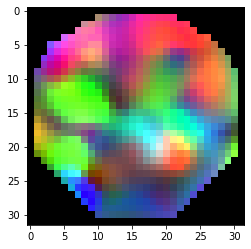

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


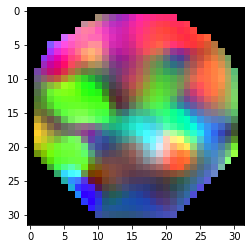

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


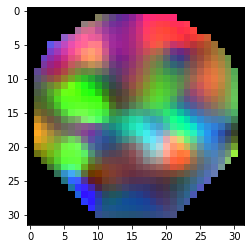

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


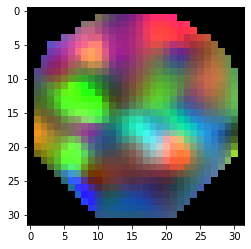

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


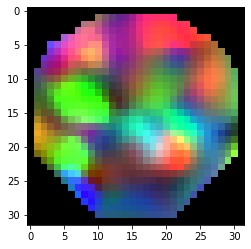

In [61]:
# for i in range(5):
#     plt.figure()
#     plt.imshow(images_F_T_F[i])
#     plt.show()